In [2]:
# Step 1 - Import Required Libraries

!pip install pandas numpy scikit-learn matplotlib seaborn plotly streamlit fastapi uvicorn joblib --quiet
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [3]:
# Step 3 - Upload & Extract Dataset

from google.colab import files
print("📂 Please upload Dataset.zip")
uploaded = files.upload()
zip_path = list(uploaded.keys())[0]
extract_path = "/content/NASA_Dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("✅ Dataset extracted successfully!")

📂 Please upload Dataset.zip


Saving Dataset.zip to Dataset.zip
✅ Dataset extracted successfully!


In [7]:
# Step 3 - Flexible Loader for NASA Dataset

def load_nasa_dataset(extract_path, fd="FD001"):
    """
    Load NASA CMAPSS dataset for a given FD (FD001–FD004).
    """
    train_path = os.path.join(extract_path, f"Dataset/Train/Train {fd}.csv")
    test_path  = os.path.join(extract_path, f"Dataset/Test/Test {fd}.csv")
    rul_path   = os.path.join(extract_path, f"Dataset/RUL/RUL {fd}.csv")
    # Column names
    cols = ["unit_number","time_in_cycles"] + \
           [f"operational_setting_{i}" for i in range(1,4)] + \
           [f"sensor_measurement_{i}" for i in range(1,22)]
    # Load train
    train_df = pd.read_csv(train_path, sep=" ", header=None)
    train_df = train_df.dropna(axis=1, how='all')
    train_df.columns = cols
    # Load test
    test_df = pd.read_csv(test_path, sep=" ", header=None)
    test_df = test_df.dropna(axis=1, how='all')
    test_df.columns = cols
    # Load RUL
    rul_df = pd.read_csv(rul_path, header=None)
    print(f"✅ {fd} Loaded Successfully!")
    print("Train shape:", train_df.shape)
    print("Test shape:", test_df.shape)
    print("RUL shape:", rul_df.shape)
    return train_df, test_df, rul_df
# Example - Load FD001
train_df, test_df, rul_df = load_nasa_dataset(extract_path, fd="FD001")
train_df.head(50)

✅ FD001 Loaded Successfully!
Train shape: (20631, 26)
Test shape: (13096, 26)
RUL shape: (100, 1)


,unit_number,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,522.32,2388.03,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,522.47,2388.03,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,521.79,2388.05,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,521.79,2388.06,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694


In [8]:
# Step 4 - Preprocessing & Feature Engineering

def preprocess_data(train_df):
    # Compute RUL (Remaining Useful Life)
    rul_train = train_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    rul_train.columns = ['unit_number','max_cycle']
    train_df = train_df.merge(rul_train, on='unit_number', how='left')
    train_df['RUL'] = train_df['max_cycle'] - train_df['time_in_cycles']
    train_df.drop(columns=['max_cycle'], inplace=True)
    # Select features (sensors + operational settings)
    features = [col for col in train_df.columns if "sensor" in col or "operational" in col]
    # Normalize
    scaler = StandardScaler()
    train_df[features] = scaler.fit_transform(train_df[features])
    return train_df, features, scaler
train_df, features, scaler = preprocess_data(train_df)
print("✅ Preprocessing done. Features count:", len(features))
train_df.head(50)

✅ Preprocessing done. Features count: 24


,unit_number,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,RUL
0,1,1,-0.315980,-1.372953,0.0,0.0,-1.721725,-0.134255,-0.925936,-1.776357e-15,...,-1.058890,-0.269071,-0.603816,-1.387779e-17,-0.781710,0.0,0.0,1.348493,1.194427,191
1,1,2,0.872722,-1.031720,0.0,0.0,-1.061780,0.211528,-0.643726,-1.776357e-15,...,-0.363646,-0.642845,-0.275852,-1.387779e-17,-0.781710,0.0,0.0,1.016528,1.236922,190
2,1,3,-1.961874,1.015677,0.0,0.0,-0.661813,-0.413166,-0.525953,-1.776357e-15,...,-0.919841,-0.551629,-0.649144,-1.387779e-17,-2.073094,0.0,0.0,0.739891,0.503423,189
3,1,4,0.324090,-0.008022,0.0,0.0,-0.661813,-1.261314,-0.784831,-1.776357e-15,...,-0.224597,-0.520176,-1.971665,-1.387779e-17,-0.781710,0.0,0.0,0.352598,0.777792,188
4,1,5,-0.864611,-0.690488,0.0,0.0,-0.621816,-1.251528,-0.301518,-1.776357e-15,...,-0.780793,-0.521748,-0.339845,-1.387779e-17,-0.136018,0.0,0.0,0.463253,1.059552,187
5,1,6,-1.961874,-0.349255,0.0,0.0,-1.161771,-0.987297,-1.173703,-1.776357e-15,...,-0.919841,-0.571550,-0.835790,-1.387779e-17,-1.427402,0.0,0.0,0.905873,0.713126,186
6,1,7,0.461248,0.333211,0.0,0.0,-0.401834,0.293081,-1.240367,-1.776357e-15,...,-0.919841,-0.599334,-1.193084,-1.387779e-17,-0.781710,0.0,0.0,1.569803,0.810125,185
7,1,8,-1.550401,1.015677,0.0,0.0,-0.241847,-1.233586,-0.884827,-1.776357e-15,...,-0.919841,-0.664862,-0.921114,-1.387779e-17,-1.427402,0.0,0.0,0.850546,0.193025,184
8,1,9,0.369810,0.333211,0.0,0.0,-1.121775,0.074520,-1.570353,-1.776357e-15,...,-0.641744,-0.946896,-1.849012,-1.387779e-17,-0.781710,0.0,0.0,1.293165,1.079876,183
9,1,10,-1.504681,0.333211,0.0,0.0,-1.941707,0.116927,-0.941491,-1.776357e-15,...,-0.502695,-0.753457,-0.361176,-1.387779e-17,-0.136018,0.0,0.0,0.739891,1.660023,182


X_train shape: (14104, 30, 24)
X_val shape: (3527, 30, 24)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 30, 128)        │        78,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,857 (507.25 KB)

 Trainable params: 129,857 (507.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - loss: 8650.2061 - mae: 74.7440 - val_loss: 5628.2847 - val_mae: 59.3149 - learning_rate: 0.0010
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 3508.3284 - mae: 48.4547 - val_loss: 5430.5864 - val_mae: 58.8314 - learning_rate: 0.0010
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - loss: 3422.7195 - mae: 47.6360 - val_loss: 5388.2275 - val_mae: 58.7509 - learning_rate: 0.0010
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 22s 102ms/step - loss: 3501.0864 - mae: 48.5361 - val_loss: 5458.7173 - val_mae: 58.8905 - learning_rate: 0.0010
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 38s 89ms/step - loss: 3586.4919 - mae: 48.9514 - val_loss: 5474.3799 - val_mae: 58.9245 - learning_rate: 0.0010
Epoch 6/50
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 3523.2505 - mae: 48.5607
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
221/221 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - loss: 3522.8997 - mae: 48.5586 

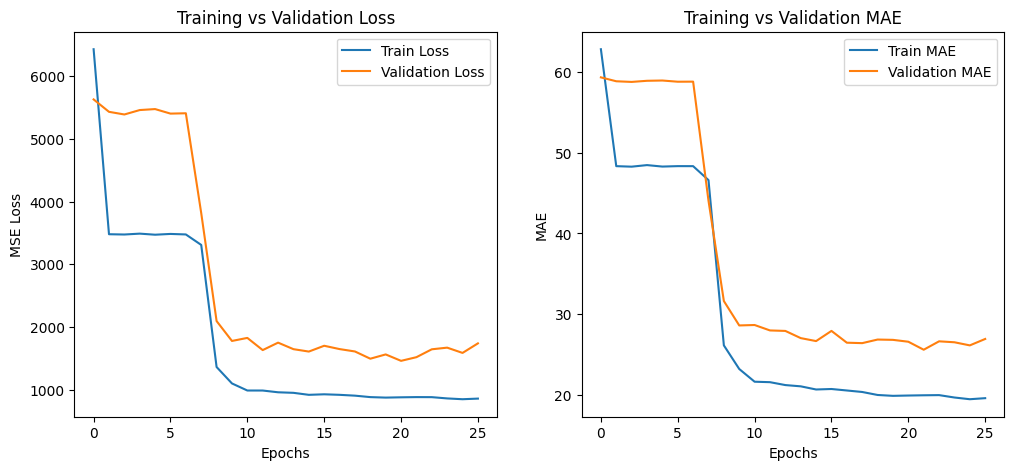

['scaler.pkl']

In [16]:
# Step 5 - LSTM Model Training

!pip install tensorflow --quiet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input   # ✅ Added Input here
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import joblib
# Scale features
scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
# Create sequences per engine
def create_sequences(df, features, seq_length=30):
    X, y = [], []
    for engine_id in df['unit_number'].unique():
        engine_data = df[df['unit_number'] == engine_id].sort_values('time_in_cycles')
        sensor_data = engine_data[features].values
        rul_data = engine_data['RUL'].values
        for i in range(len(sensor_data) - seq_length):
            X.append(sensor_data[i:i+seq_length])
            y.append(rul_data[i+seq_length])
    return np.array(X), np.array(y)
SEQ_LEN = 30
X, y = create_sequences(train_df, features, seq_length=SEQ_LEN)
# Train/Validation split
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
# Build Advanced LSTM Model
model = Sequential([
    Input(shape=(SEQ_LEN, len(features))),
    LSTM(128, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_lstm_model.keras", monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    verbose=1
)
# Evaluate
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"📊 Advanced Model Performance:\nMAE: {val_mae:.2f}\nRMSE: {np.sqrt(val_loss):.2f}")
# Plot training curves
plt.figure(figsize=(12,5))
# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
# MAE curve
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training vs Validation MAE")
plt.legend()
plt.show()
# Save Model & Scaler
model.save("final_predictive_maintenance_lstm.keras")
joblib.dump(scaler, "scaler.pkl")

In [19]:
# Step 6 - Real-time Monitoring & Alerting System

import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
import time
# Load saved model and scaler
model = tf.keras.models.load_model("final_predictive_maintenance_lstm.keras")
scaler = joblib.load("scaler.pkl")
# Real-time monitoring function
def simulate_real_time_monitoring(test_df, features, seq_len=30, threshold=20, last_n=20):
    engines = test_df['unit_number'].unique()
    for engine_id in engines:
        engine_data = test_df[test_df['unit_number'] == engine_id].sort_values('time_in_cycles')
        # Scale using DataFrame to preserve feature names -> fixes warning
        sensor_data_scaled = pd.DataFrame(
            scaler.transform(engine_data[features]),
            columns=features
        ).values
        # Monitor only last N cycles
        start_idx = max(seq_len, len(sensor_data_scaled) - last_n)
        print(f"\n🔍 Monitoring Engine {engine_id} (last {last_n} cycles)...")
        for i in range(start_idx, len(sensor_data_scaled)):
            X_live = np.expand_dims(sensor_data_scaled[i-seq_len:i], axis=0)
            predicted_rul = model.predict(X_live, verbose=0)[0][0]
            if predicted_rul < threshold:
                print(f"🚨 ALERT | Engine {engine_id} | Cycle {engine_data.iloc[i]['time_in_cycles']} "
                      f"| Predicted RUL: {predicted_rul:.2f}")
            # Simulate streaming delay (optional)
            time.sleep(0.3)
# Example usage
simulate_real_time_monitoring(test_df, features, seq_len=30, threshold=25, last_n=20)


🔍 Monitoring Engine 1 (last 20 cycles)...
🚨 ALERT | Engine 1 | Cycle 31.0 | Predicted RUL: 5.59

🔍 Monitoring Engine 2 (last 20 cycles)...
🚨 ALERT | Engine 2 | Cycle 31.0 | Predicted RUL: 5.59
🚨 ALERT | Engine 2 | Cycle 32.0 | Predicted RUL: 5.59
🚨 ALERT | Engine 2 | Cycle 33.0 | Predicted RUL: 5.59
🚨 ALERT | Engine 2 | Cycle 34.0 | Predicted RUL: 5.59
🚨 ALERT | Engine 2 | Cycle 35.0 | Predicted RUL: 5.59
🚨 ALERT | Engine 2 | Cycle 36.0 | Predicted RUL: 5.59
🚨 ALERT | Engine 2 | Cycle 37.0 | Predicted RUL: 5.59
🚨 ALERT | Engine 2 | Cycle 38.0 | Predicted RUL: 5.59
🚨 ALERT | Engine 2 | Cycle 39.0 | Predicted RUL: 5.59
🚨 ALERT | Engine 2 | Cycle 40.0 | Predicted RUL: 5.59
🚨 ALERT | Engine 2 | Cycle 41.0 | Predicted RUL: 5.59
🚨 ALERT | Engine 2 | Cycle 42.0 | Predicted RUL: 5.59
🚨 ALERT | Engine 2 | Cycle 43.0 | Predicted RUL: 5.59
🚨 ALERT | Engine 2 | Cycle 44.0 | Predicted RUL: 5.59
🚨 ALERT | Engine 2 | Cycle 45.0 | Predicted RUL: 5.59
🚨 ALERT | Engine 2 | Cycle 46.0 | Predicted RUL: 5

In [36]:
# Step 7 - Streamlit App Creation

app_code = """
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
import plotly.graph_objects as go

# ----------------- LOAD MODEL & SCALER ----------------- #
model = tf.keras.models.load_model("final_predictive_maintenance_lstm.keras", compile=False, safe_mode=False)
scaler = joblib.load("scaler.pkl")

# Features used in training (must match exactly!)
features = [
    "operational_setting_1",
    "operational_setting_2",
    "operational_setting_3"
] + [f"sensor_measurement_{i}" for i in range(1, 22)]   # 21 sensors

seq_len = 30

# ----------------- SAFE PREDICT WRAPPER ----------------- #
def safe_predict(model, X):
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    preds = model(X, training=False)   # forward pass only
    return preds.numpy()

# ----------------- STREAMLIT LAYOUT ----------------- #
st.set_page_config(page_title="⚙️ Equipment Health Dashboard", layout="wide")

st.title("⚙️ Equipment Health Monitoring Dashboard")
st.markdown("A real-time predictive maintenance dashboard powered by **LSTM Deep Learning**.")

# Sidebar settings
st.sidebar.header("⚙️ Controls")
threshold = st.sidebar.slider("Failure Alert Threshold (RUL)", 5, 50, 20)
last_n = st.sidebar.slider("Show Last N Cycles", 10, 100, 30)
engine_ids = st.sidebar.multiselect("Select Engines to Monitor", [1, 2, 3, 4, 5], default=[1])

# Auto-refresh every 5 seconds
try:
    from streamlit_autorefresh import st_autorefresh
except ImportError:
    def st_autorefresh(*args, **kwargs):
        return 0
count = st_autorefresh(interval=5000, key="refresh_counter")

# ----------------- SIMULATED TEST DATA ----------------- #
def generate_engine_data(engine_id, n_cycles=200):
    np.random.seed(engine_id)
    cycles = np.arange(1, n_cycles + 1)

    df = pd.DataFrame({
        "unit_number": engine_id,
        "time_in_cycles": cycles,
        "operational_setting_1": np.random.uniform(-1, 1, n_cycles),
        "operational_setting_2": np.random.uniform(0, 1, n_cycles),
        "operational_setting_3": np.random.uniform(0, 1, n_cycles),
    })

    # Add 21 sensor signals
    for i in range(1, 22):
        df[f"sensor_measurement_{i}"] = np.sin(cycles / (10+i)) + np.random.normal(0, 0.1, n_cycles)

    # Scale features
    df[features] = scaler.transform(df[features])
    return df

# ----------------- GLOBAL ALERT TRACKING ----------------- #
global_status = "✅ All Engines Healthy"
global_color = "green"
engine_status = {}

for engine_id in engine_ids:
    df = generate_engine_data(engine_id)
    max_cycle = min(seq_len + count, len(df))
    stream_df = df.iloc[:max_cycle]

    preds, rul_cycles = [], []
    for i in range(seq_len, len(stream_df)):
        X_live = np.expand_dims(stream_df[features].iloc[i-seq_len:i].values, axis=0)
        predicted_rul = max(0, safe_predict(model, X_live)[0][0])  # <-- FIXED
        preds.append(predicted_rul)
        rul_cycles.append(stream_df.iloc[i]["time_in_cycles"])

    if len(preds) > 0:
        latest_rul = preds[-1]
        status = "✅ Healthy"
        color = "green"
        if latest_rul < threshold/2:
            status, color = "🔴 Critical", "red"
        elif latest_rul < threshold:
            status, color = "🟠 Warning", "orange"

        engine_status[engine_id] = (status, color, rul_cycles, preds)

        # Update global status
        if color == "red":
            global_status, global_color = "🚨 CRITICAL ALERT: Immediate Maintenance Required!", "red"
        elif color == "orange" and global_color != "red":
            global_status, global_color = "⚠️ Warning: Some Engines Need Attention", "orange"

# ----------------- DISPLAY GLOBAL ALERT BANNER ----------------- #
st.markdown(f\"\"\"
<div style='padding:15px; border-radius:10px; background-color:{global_color};
color:white; font-size:20px; font-weight:bold; text-align:center;'>
{global_status}
</div>
\"\"\", unsafe_allow_html=True)

# ----------------- PER-ENGINE VISUALIZATION ----------------- #
for engine_id, (status, color, rul_cycles, preds) in engine_status.items():
    st.markdown(f"### Engine {engine_id} Status: <span style='color:{color}; font-weight:bold;'>{status}</span>", unsafe_allow_html=True)

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=rul_cycles[-last_n:],
        y=preds[-last_n:],
        mode="lines+markers",
        name="Predicted RUL",
        line=dict(color="blue", width=3),
        marker=dict(size=8)
    ))
    fig.add_hline(y=threshold, line_dash="dash", line_color="red", annotation_text="Threshold", annotation_position="top right")
    fig.update_layout(
        title=f"📉 Predicted Remaining Useful Life (Engine {engine_id})",
        xaxis_title="Cycle",
        yaxis_title="Predicted RUL",
        template="plotly_white",
        height=400,
        margin=dict(l=20, r=20, t=60, b=20),
    )
    st.plotly_chart(fig, use_container_width=True)

    st.subheader(f"Recent Predictions (Engine {engine_id})")
    recent_df = pd.DataFrame({
        "Cycle": rul_cycles[-last_n:],
        "Predicted_RUL": preds[-last_n:]
    })
    st.dataframe(recent_df, use_container_width=True)
"""
# Save to file
with open("app.py", "w") as f:
    f.write(app_code)

In [37]:
# Step 8 - Streamlit App Deployment

# Install necessary packages
!pip install -q streamlit pyngrok streamlit-autorefresh
# Import required libraries
import os
import time
from pyngrok import ngrok, conf
# Configure Ngrok Authentication
NGROK_AUTH_TOKEN = "2z0Oqv0tD166fELGCHwV2gLZwq1_2G2zUQRSs6C27k9vdzxwq"
conf.get_default().auth_token = NGROK_AUTH_TOKEN
# Create logs directory
LOG_DIR = "/content/logs"
os.makedirs(LOG_DIR, exist_ok=True)
# Run Streamlit app in background
!streamlit run app.py --server.port 8501 --server.address 0.0.0.0 > {LOG_DIR}/app_log.txt 2>&1 &
# Give Streamlit a few seconds to start
time.sleep(7)
# Connect Ngrok to the running Streamlit app
public_url = ngrok.connect(8501, "http")
print("🚀 Your Streamlit app is live at:", public_url.public_url)

🚀 Your Streamlit app is live at: https://2f363df598ef.ngrok-free.app
